## Bird Migration Analysis  

**Overview**  
This project studies bird migration patterns using the Bird Migration dataset. Migration refers to the seasonal movement of birds between breeding and non-breeding areas, and analyzing it helps in conservation and understanding environmental impacts.  

**Objectives**  
- Measure migration distances and durations  
- Explore species, regional, and seasonal patterns  
- Identify environmental and behavioral factors  

**Methodology**  
- **Data Processing**: Cleaned dataset with PySpark (handled missing values, duplicates)  
- **Analysis**: Calculated stats (distance, duration, speed) and grouped by species & months  
- **Visualization**: Converted to Pandas, plotted with Seaborn/Matplotlib  
  - Histogram (distance distribution)  
  - Pie chart (species distribution)  
  - Line plot (distance by month)  
  - Scatter plot (distance vs duration)  
  - Bar chart (top species by distance & count)  


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, max as spark_max, round as spark_round

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Create Spark session
spark = SparkSession.builder.appName("Bird Migration Analysis").getOrCreate()


In [2]:
# Load CSV using PySpark
df = spark.read.csv("bird_migration_with_origin_destination.csv", header=True, inferSchema=True)
print("CSV file Data loaded")

CSV file Data loaded


In [3]:
# Print schema and missing values
df.printSchema()
print("Total records:", df.count())
for column in df.columns:
    print(f"{column} nulls:", df.filter(col(column).isNull()).count())

root
 |-- Bird_ID: string (nullable = true)
 |-- Species: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Habitat: string (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- Migration_Reason: string (nullable = true)
 |-- Start_Latitude: double (nullable = true)
 |-- Start_Longitude: double (nullable = true)
 |-- End_Latitude: double (nullable = true)
 |-- End_Longitude: double (nullable = true)
 |-- Flight_Distance_km: double (nullable = true)
 |-- Flight_Duration_hours: double (nullable = true)
 |-- Average_Speed_kmph: double (nullable = true)
 |-- Max_Altitude_m: integer (nullable = true)
 |-- Min_Altitude_m: integer (nullable = true)
 |-- Temperature_C: double (nullable = true)
 |-- Wind_Speed_kmph: double (nullable = true)
 |-- Humidity_%: integer (nullable = true)
 |-- Pressure_hPa: double (nullable = true)
 |-- Visibility_km: double (nullable = true)
 |-- Nesting_Success: string (nullable = true)
 |-- Tag_Battery_Level_%: integer (nullable

In [4]:
# Display all unique migration start months in ascending order
df.select("Migration_Start_Month").distinct().orderBy("Migration_Start_Month").show()

+---------------------+
|Migration_Start_Month|
+---------------------+
|                  Apr|
|                  Feb|
|                  Jan|
|                  Mar|
|                  May|
|                  Nov|
|                  Oct|
|                  Sep|
+---------------------+



In [5]:
df.select("Flight_Distance_km","Flight_Duration_hours","Average_Speed_kmph").describe().show()

+-------+------------------+---------------------+------------------+
|summary|Flight_Distance_km|Flight_Duration_hours|Average_Speed_kmph|
+-------+------------------+---------------------+------------------+
|  count|             10000|                10000|             10000|
|   mean| 2504.036133999996|    49.99401999999981| 49.95339399999985|
| stddev| 499.7232981331803|    10.02610814444232|  5.08529616683969|
|    min|             527.7|                 12.6|             30.43|
|    max|           4428.32|                 91.0|             68.95|
+-------+------------------+---------------------+------------------+



In [6]:
# Top 10 species by average flight distance
df.groupBy("Species") \
  .agg(spark_round(avg("Flight_Distance_km"), 4).alias("avg_distance")) \
  .orderBy(col("avg_distance").desc()) \
  .show(10)

+-------+------------+
|Species|avg_distance|
+-------+------------+
|  Stork|   2536.6328|
|  Eagle|   2514.8051|
|   Hawk|   2512.7926|
|Swallow|   2500.5819|
|Warbler|   2498.5905|
|  Goose|   2496.0231|
|  Crane|    2467.413|
+-------+------------+



In [7]:
# Top 10 species by maximum flight distance
df.groupBy("Species") \
  .agg(spark_round(spark_max("Flight_Distance_km"), 4).alias("max_distance")) \
  .orderBy(col("max_distance").desc()) \
  .show(10)

+-------+------------+
|Species|max_distance|
+-------+------------+
|  Stork|     4428.32|
|Warbler|     4227.82|
|   Hawk|      4214.8|
|Swallow|     4183.92|
|  Eagle|     4135.51|
|  Crane|     4037.34|
|  Goose|     4029.05|
+-------+------------+



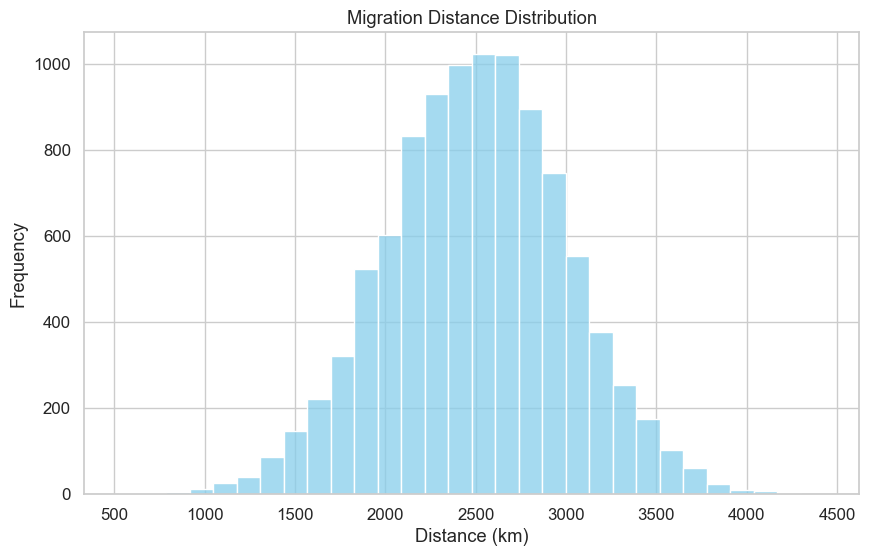

In [8]:
# Histogram: Migration Distance Distribution
distance_pd = df.select("Flight_Distance_km").toPandas()

plt.figure(figsize=(10,6))
sns.histplot(distance_pd['Flight_Distance_km'], bins=30, kde=False, color="skyblue")
plt.title("Migration Distance Distribution")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()

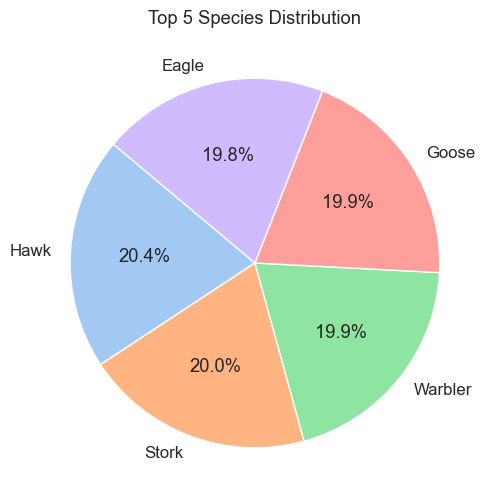

In [9]:
#Pie Chart: Top 5 Species Distribution

top5_species = df.groupBy("Species").count().orderBy(col("count").desc()).limit(5).toPandas()

plt.figure(figsize=(6,6))
plt.pie(top5_species['count'], labels=top5_species['Species'], autopct="%1.1f%%",
        colors=sns.color_palette("pastel", 5), startangle=140)
plt.title("Top 5 Species Distribution")
plt.ylabel("")
plt.show()

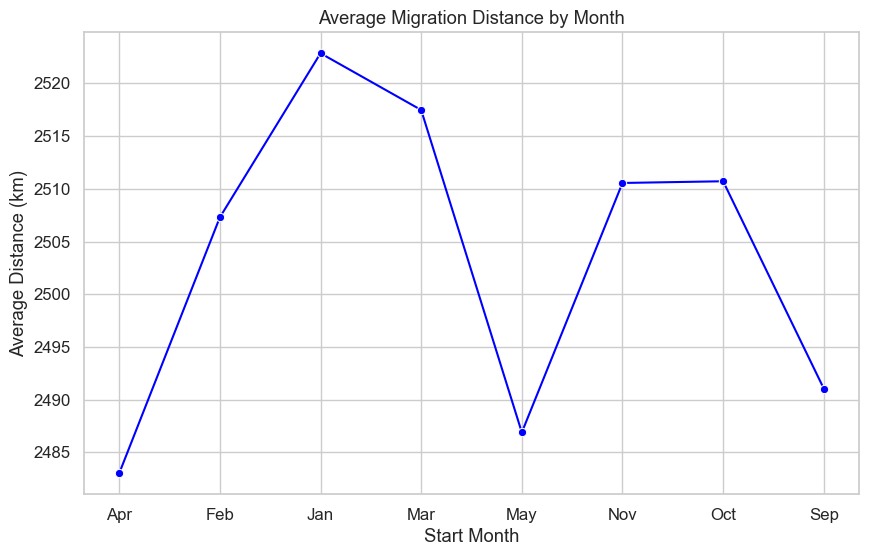

In [10]:
# Line Plot: Average Migration Distance by Month
monthly_avg = df.groupBy("Migration_Start_Month") \
                .agg(spark_round(avg("Flight_Distance_km"), 4).alias("avg_distance")) \
                .orderBy("Migration_Start_Month") \
                .toPandas()

plt.figure(figsize=(10,6))
sns.lineplot(x="Migration_Start_Month", y="avg_distance", data=monthly_avg, marker="o", color="blue")
plt.title("Average Migration Distance by Month")
plt.xlabel("Start Month")
plt.ylabel("Average Distance (km)")
plt.grid(True)
plt.show()

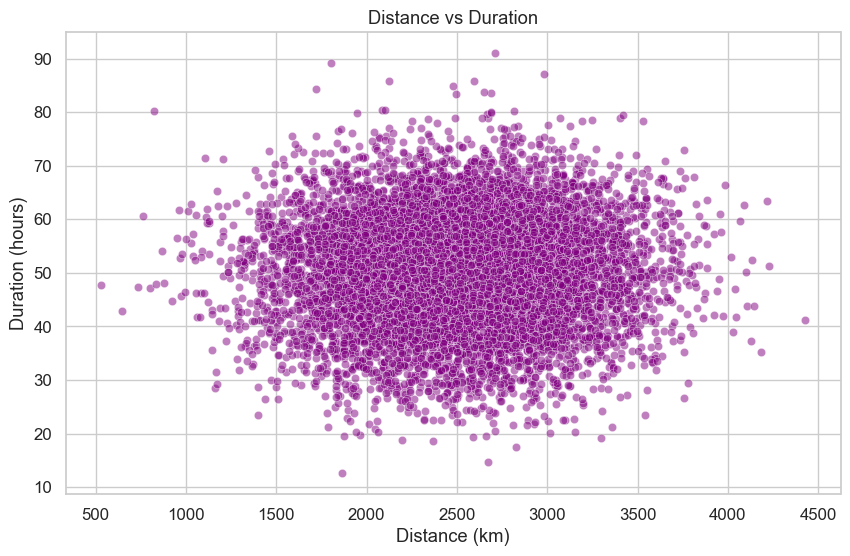

In [11]:
# Scatter Plot: Distance vs Duration
scatter_pd = df.select("Flight_Distance_km", "Flight_Duration_hours").toPandas()

plt.figure(figsize=(10,6))
sns.scatterplot(data=scatter_pd, x="Flight_Distance_km", y="Flight_Duration_hours",
                alpha=0.5, color="purple")
plt.title("Distance vs Duration")
plt.xlabel("Distance (km)")
plt.ylabel("Duration (hours)")
plt.show()

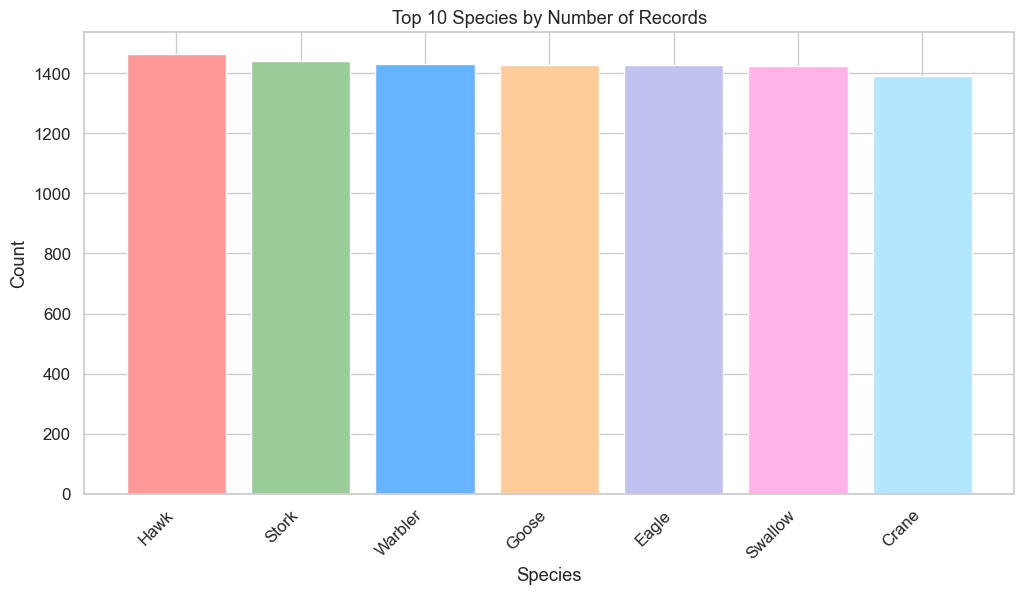

In [12]:
# Bar Chart: Top 10 Species by Number of Records

top10_species_pd = df.groupBy("Species").count() \
                     .orderBy(col("count").desc()) \
                     .limit(10) \
                     .toPandas()

# Colors matching the pie chart palette (soft pastel)
colors = ['#ff9999', '#99cc99', '#66b3ff', '#ffcc99', '#c2c2f0', '#ffb3e6', '#b3e6ff', '#ffb366', '#c2f0c2', '#ff6666']

plt.figure(figsize=(12,6))
plt.bar(x=top10_species_pd['Species'], height=top10_species_pd['count'], color=colors)
plt.title("Top 10 Species by Number of Records")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()

### Conclusion

The study shows that bird migration is shaped by species traits, seasonal cycles, and environmental factors.  
Analysis revealed strong links between distance, duration, and speed.  
Storks, eagles, and hawks emerged as key long-distance migrators. Seasonal patterns highlighted peak migrations during specific months. A few dominant species accounted for most migration activity.  
These insights can guide conservation planning and habitat protection.